In [15]:
from mpu6050 import mpu6050
from matplotlib import pyplot as plt
import json
import numpy as np
from ahrs.filters import Madgwick as ahrsMadgwick
from ahrs.filters import AQUA as ahrsAQUA
import numpy as np
import time
import math

def deg2rad(dat):
    return {'x': np.deg2rad(dat['x']), 'y': np.deg2rad(dat['y']), 'z': np.deg2rad(dat['z'])}
def dict2arr(dat):
    return [dat['x'], dat['y'], dat['z']]

def plot_raw(x, y, title):
    fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize= (10, 5))
    ys = [[[el['a']['x'] for el in y], [el['a']['y'] for el in y], [el['a']['z'] for el in y]],
          [[el['g']['x'] for el in y], [el['g']['y'] for el in y], [el['g']['z'] for el in y]]]
    clrs = ['r', 'g', 'b']
    x_label = "time, s"
    y_labels = ["acceleration, m/s^2", "angular, degrees/s"]
    s_titles2 = ["X", "Y", "Z"]
    s_titles1 = ["Acc", "Gyro"]

    for i in range(2):
        for j in range(3):
            axs[i][j].plot(x, ys[i][j], clrs[j])
            if i == 0 and j == 2:
                axs[i][j].plot(x, [9.8] * len(x), 'black')
            else:
                axs[i][j].plot(x, [0] * len(x), 'black')
            axs[i][j].set_title(s_titles1[i] + ": " + s_titles2[j])
            axs[i][j].set_xlabel(x_label)
            axs[i][j].set_ylabel(y_labels[i])
    fig.suptitle(title)
    plt.show()

def q2angles(qs):
    angles = []
    for q in qs:
        # pitch = math.asin(-2.0*(q[1]*q[3] - q[0]*q[2]))
        # roll = math.atan2(2.0*(q[1]*q[2] + q[0]*q[3]), q[0]**2 + q[1]**2 - q[2]**2 - q[3]**2)
        ww = q[0]
        xx = q[1]
        yy = q[2]
        zz = q[3]
        t0 = +2.0 * (ww * xx + yy * zz)
        t1 = +1.0 - 2.0 * (xx * xx + yy * yy)
        roll = math.atan2(t0, t1)
     
        t2 = +2.0 * (ww * yy - zz * xx)
        t2 = +1.0 if t2 > +1.0 else t2
        t2 = -1.0 if t2 < -1.0 else t2
        pitch = math.asin(t2)
        angles.append({'pitch': math.degrees(pitch), 'roll': math.degrees(roll)})
    return angles

def plot_angles(x, angles, title):
    # figure = plt.figure(figsize= (10, 5))

    fig, axs = plt.subplots(1, 2, constrained_layout=True, figsize= (10, 5))
    fig.suptitle(title)
    yk = ['roll', 'pitch']
    clrs = ['c', 'm']
    x_label = "time, s"
    y_label = "degrees"
    s_titles = ["Roll", "Pitch"]

    for i in range(2):
        axs[i].plot(x, [el[yk[i]] for el in angles], clrs[i])
        axs[i].set_title(s_titles[i])
        axs[i].set_xlabel(x_label)
        axs[i].set_ylabel(y_label)
        axs[i].plot(x, [0] * len(x), 'black')
    plt.show()
    
    # plt.subplot(121)
    # plt.plot(x, [el['roll'] for el in angles], 'r')
    # plt.plot(x, [0] * len(x), 'black')
    # plt.subplot(122)
    # plt.plot(x, [el['pitch'] for el in angles], 'g')
    # plt.plot(x, [0] * len(x), 'black')
    # plt.show()

    for k in ['roll', 'pitch']:
        print(f"Avg {k}: ", "%.5lf" % (sum([el[k] for el in angles])/len(x)))
        print(f"Std {k}: ", "%.5lf" % np.std([el[k] for el in angles]), "\n")

def apply_madgwick(x, y, avgt, gain = 0.033):
    madgwick = ahrsMadgwick(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                                    gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]),
                                    acc = np.array([dict2arr(t['a']) for t in y]),
                                    gain = gain)
    angles = q2angles(madgwick.Q)
    plot_angles(x, angles, f"Madgwick, gain = {gain}")


def apply_aqua(x, y, avgt, alpha= 0.01, threshold= 0.9, adaptive= False):
    aqua = ahrsAQUA(q0 = np.tile([1., 0., 0., 0.], (1)), Dt = avgt, frequancy= avgt ** (-1),
                        gyr= np.array([dict2arr(deg2rad(t['g'])) for t in y]), 
                        acc = np.array([dict2arr(t['a']) for t in y]),
                       alpha= alpha, threshold= threshold, adaptive= adaptive)
    angles = q2angles(aqua.Q)
    plot_angles(x, angles, f"AQUA, alpha = {alpha}, threshold = {threshold}, adaptive = {adaptive}")
    


def apply_comp(x, y, avgt, alpha=0.5):
    angles = [{'roll': 0., 'pitch': 0}]
    for i in range(1, len(x)):
        # print("ggggg= ", (y[i]['g'])['y'] * avgt)
        pitch = (math.radians(angles[i-1]['pitch']) + deg2rad(y[i]['g'])['y'] * avgt) * alpha + (1 - alpha) * (math.atan(-y[i]['a']['x'] / math.sqrt(y[i]['a']['y'] ** 2 + y[i]['a']['z'] ** 2)))
        roll = (math.radians(angles[i-1]['roll']) + deg2rad(y[i]['g'])['x'] * avgt) * alpha + (1-alpha) * math.atan(y[i]['a']['y'] / math.sqrt(y[i]['a']['x'] ** 2 + y[i]['a']['z'] ** 2))
        angles.append({"roll": math.degrees(roll), "pitch": math.degrees(pitch)})
        # print(angles[i])
    plot_angles(x, angles, f"Простой комплементарный, gain = {alpha}")

In [20]:
def process_data(fp, title, calib=None):
    data = None
    #data/1000sampl_raw26.10.2023.13_21_10.json
    #data/angles10s26.10.2023.14_32_13.json
    #data/10000raw30.10.2023.14_32_10.json
    with open(fp) as f:
        data = json.load(f)
    start = data[0][0]
    x = [el[0] - start for el in data]
    tm = [x[i] - x[i-1] for i in range(1, len(x))]
    avgt = sum(tm)/len(tm)
    print("Avg time between measurements: ", "%.5lfs" % avgt)

    bias = {'a':{'x':0, 'y':0, 'z':9.8}, 'g':{'x':0, 'y':0, 'z':0}}
    d2k = {'acc': 'a', 'gyro': 'g'}
    for device in ['acc', 'gyro']:
        for k in ['x', 'y', 'z']:
            bias[d2k[device]][k] -= sum([el[1][d2k[device]][k] for el in data])/len(x)
            print(f"Avg {device} for {k}: ", "%.4lf" % (sum([el[1][d2k[device]][k] for el in data])/len(x)))
            print(f"Std {device} for {k}: ", "%.4lf" % np.std([el[1][d2k[device]][k] for el in data]), "\n")
            
    plot_raw(x, [el[1] for el in data], title)

    y = [el[1] for el in data]
    if calib is None:
        for device in ['a', 'g']:
            for k in ['x', 'y', 'z']:
                for i in range(len(y)):
                    y[i][device][k] = y[i][device][k] + bias[device][k]
        plot_raw(x, [el[1] for el in data], title + " (со смещением от среднего)")
    else:
        for device in ['a', 'g']:
            for k in ['x', 'y', 'z']:
                for i in range(len(y)):
                    y[i][device][k] = y[i][device][k] + calib[device][k]
        plot_raw(x, [el[1] for el in data], title + " (с заданными смещениями)")
        
    apply_comp(x, y, avgt)
    apply_madgwick(x, y, avgt)
    apply_aqua(x, y, avgt)

Avg time between measurements:  0.00826s
Avg acc for x:  0.2096
Std acc for x:  0.5789 

Avg acc for y:  -0.0624
Std acc for y:  0.8073 

Avg acc for z:  10.2331
Std acc for z:  0.2203 

Avg gyro for x:  -4.9434
Std gyro for x:  1.9353 

Avg gyro for y:  -2.4967
Std gyro for y:  1.7517 

Avg gyro for z:  -2.2081
Std gyro for z:  3.9720 



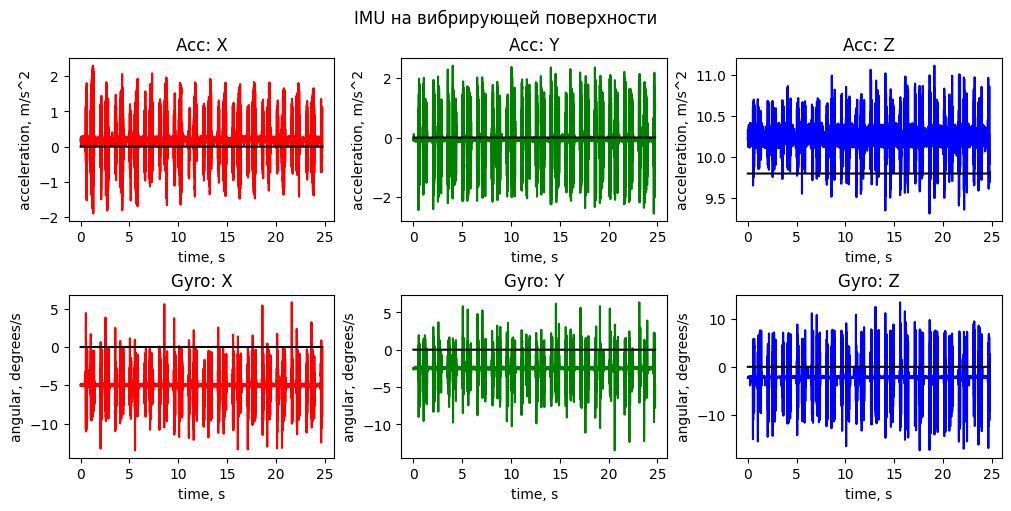

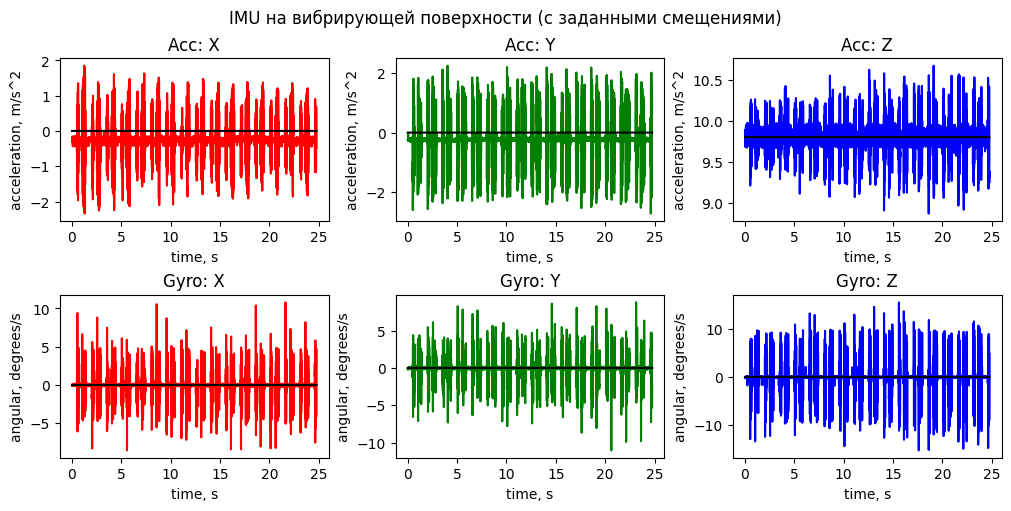

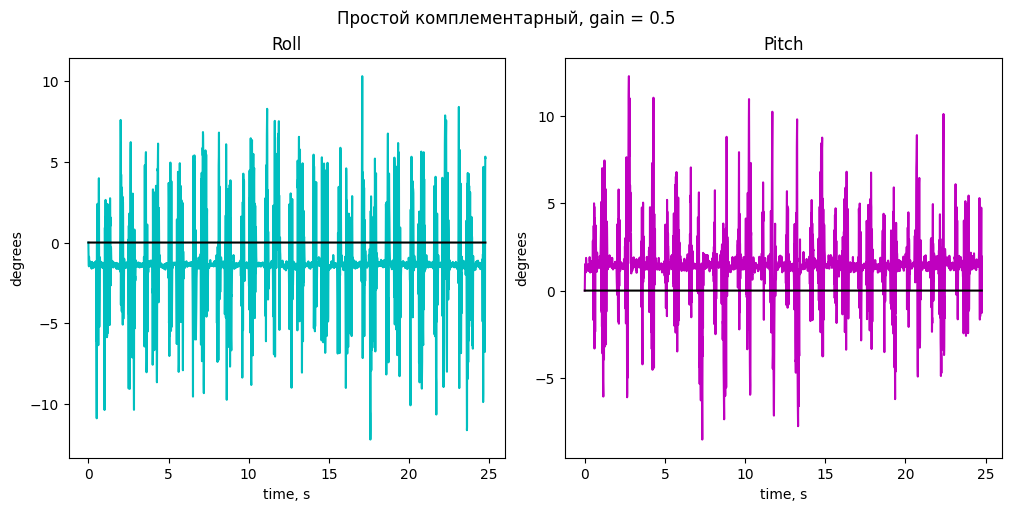

Avg roll:  -1.28718
Std roll:  2.60139 

Avg pitch:  1.39158
Std pitch:  1.97155 



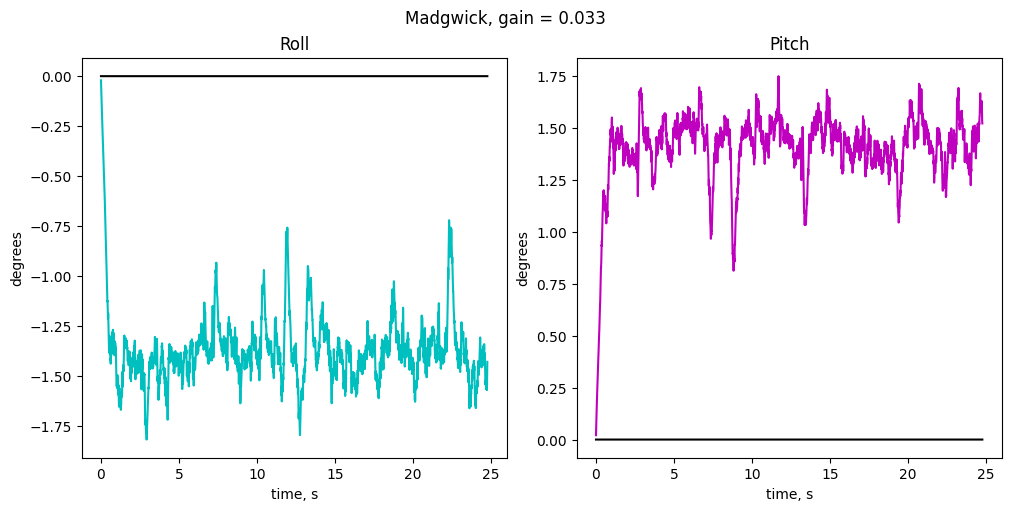

Avg roll:  -1.36931
Std roll:  0.18110 

Avg pitch:  1.40467
Std pitch:  0.17348 



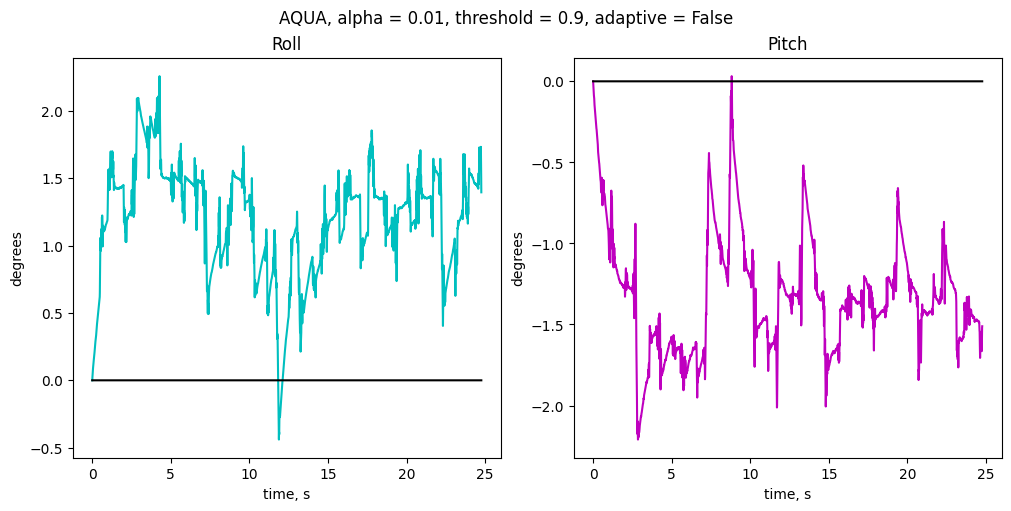

Avg roll:  1.20444
Std roll:  0.39509 

Avg pitch:  -1.31823
Std pitch:  0.35826 



In [21]:
process_data("data/3000Vibr_raw30.10.2023.15_51_45.json", "IMU на вибрирующей поверхности", calib={'a': {'x': -0.4446, 'y': -0.1665, 'z': 9.8 - 10.2432},
                                                                                                     'g': {'x': 4.9695, 'y': 2.4440, 'z': 2.1029}})

Avg time between measurements:  0.00789s
Avg acc for x:  0.4446
Std acc for x:  0.0646 

Avg acc for y:  0.1665
Std acc for y:  0.0638 

Avg acc for z:  10.2432
Std acc for z:  0.0698 

Avg gyro for x:  -4.9695
Std gyro for x:  0.0800 

Avg gyro for y:  -2.4440
Std gyro for y:  0.0841 

Avg gyro for z:  -2.1029
Std gyro for z:  0.3566 



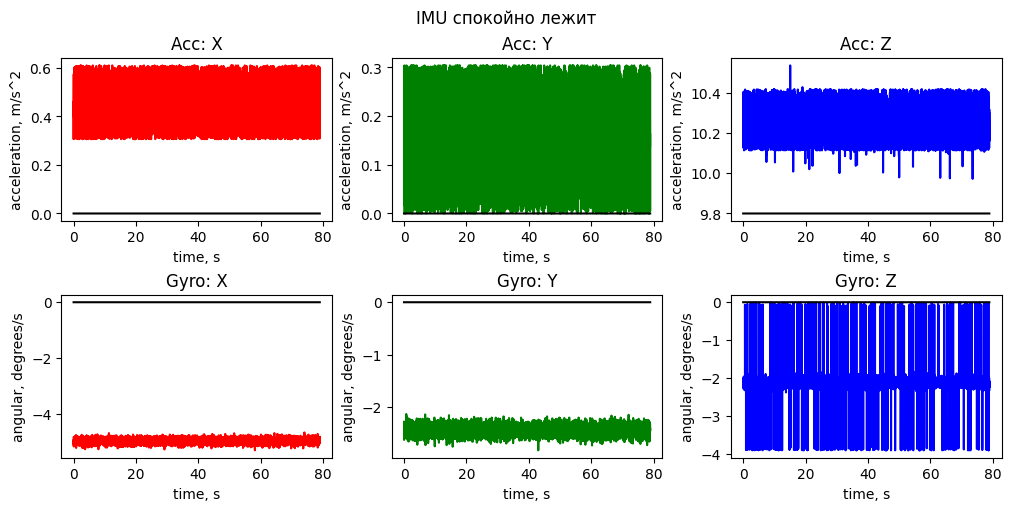

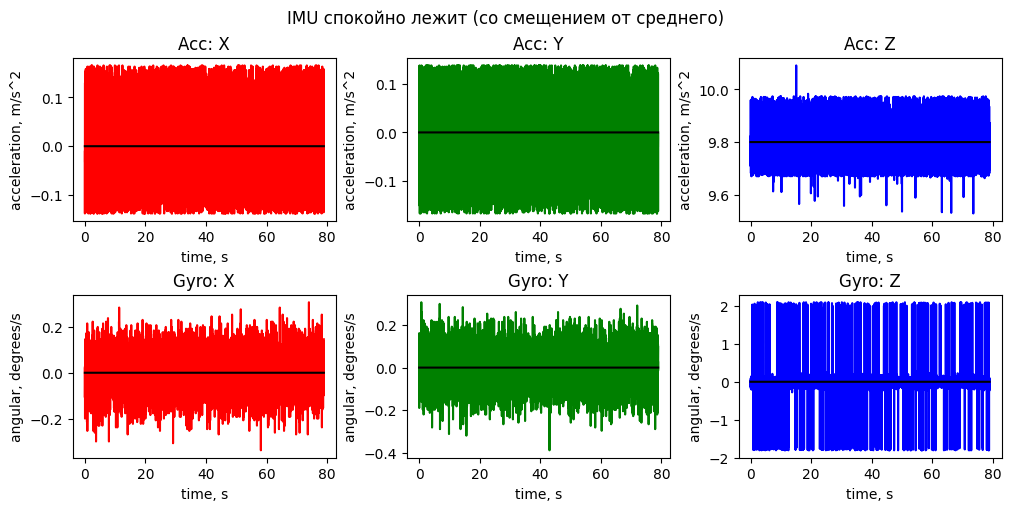

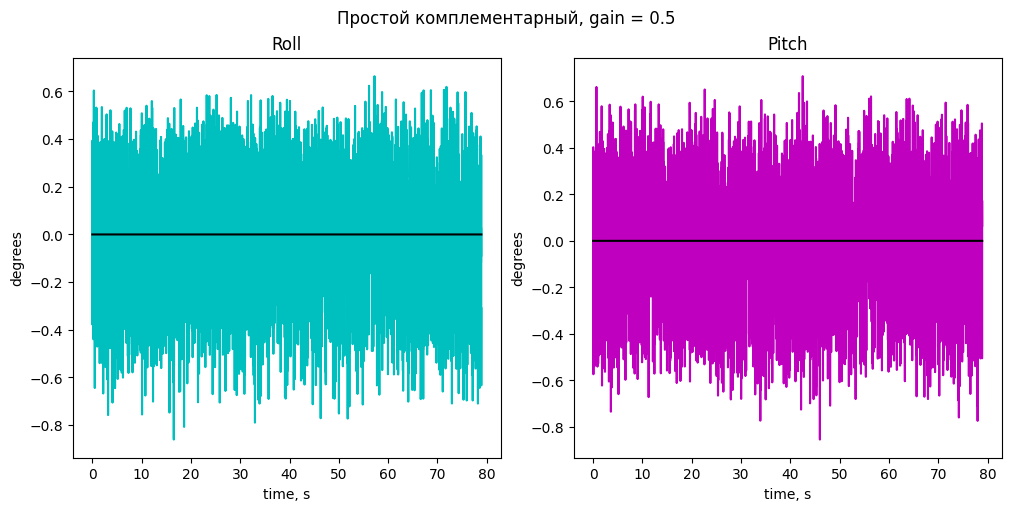

Avg roll:  0.00012
Std roll:  0.21637 

Avg pitch:  -0.00004
Std pitch:  0.21805 



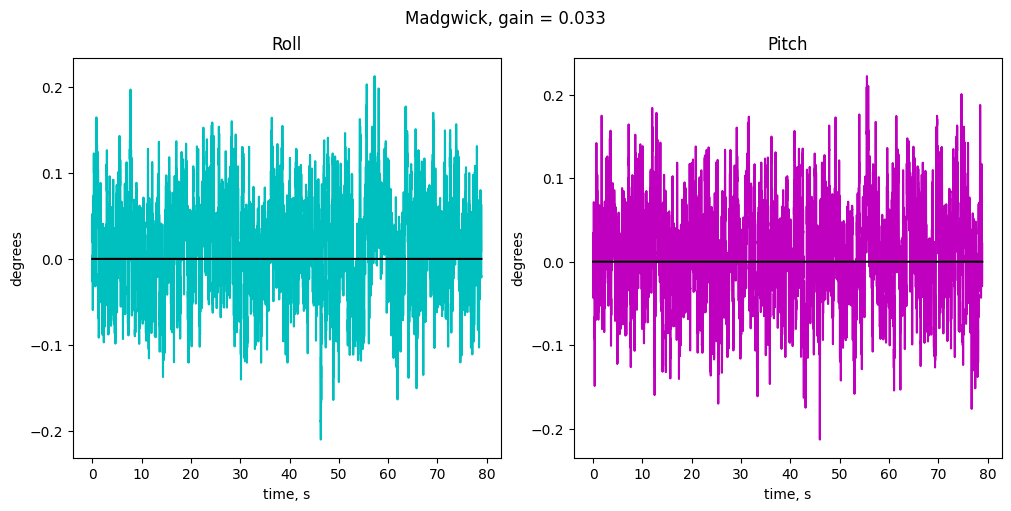

Avg roll:  0.01424
Std roll:  0.05427 

Avg pitch:  0.01057
Std pitch:  0.05823 



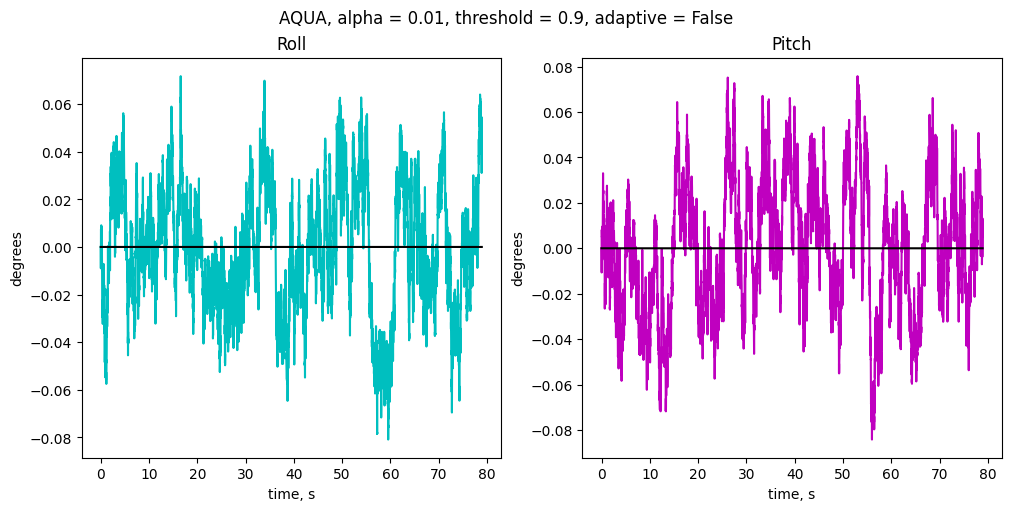

Avg roll:  -0.00061
Std roll:  0.02659 

Avg pitch:  -0.00003
Std pitch:  0.02876 



In [22]:
process_data("data/10000raw30.10.2023.14_32_10.json", "IMU спокойно лежит")

Avg time between measurements:  0.00750s
Avg acc for x:  0.1000
Std acc for x:  2.4815 

Avg acc for y:  0.2645
Std acc for y:  3.4476 

Avg acc for z:  9.2556
Std acc for z:  1.1936 

Avg gyro for x:  -4.6339
Std gyro for x:  48.9915 

Avg gyro for y:  -0.6117
Std gyro for y:  33.0439 

Avg gyro for z:  -1.3601
Std gyro for z:  34.2074 



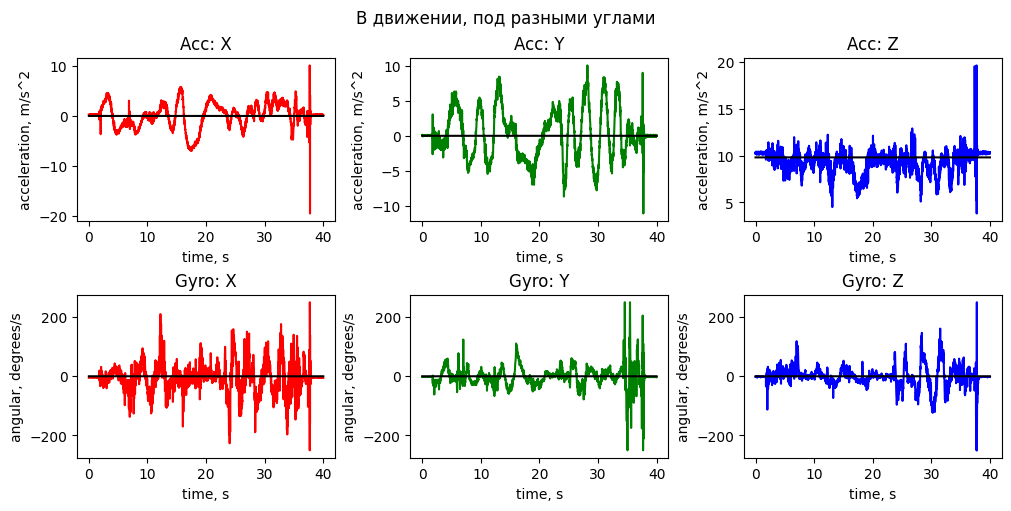

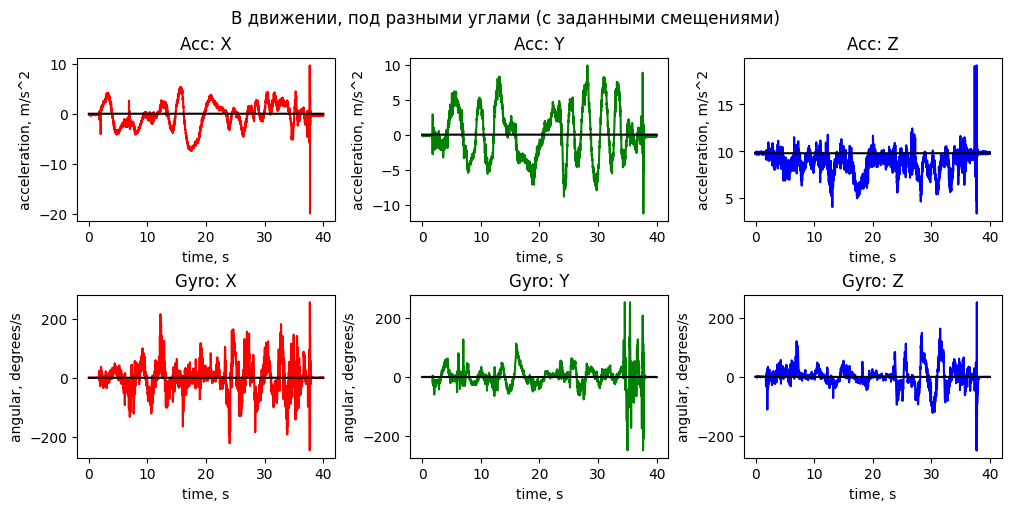

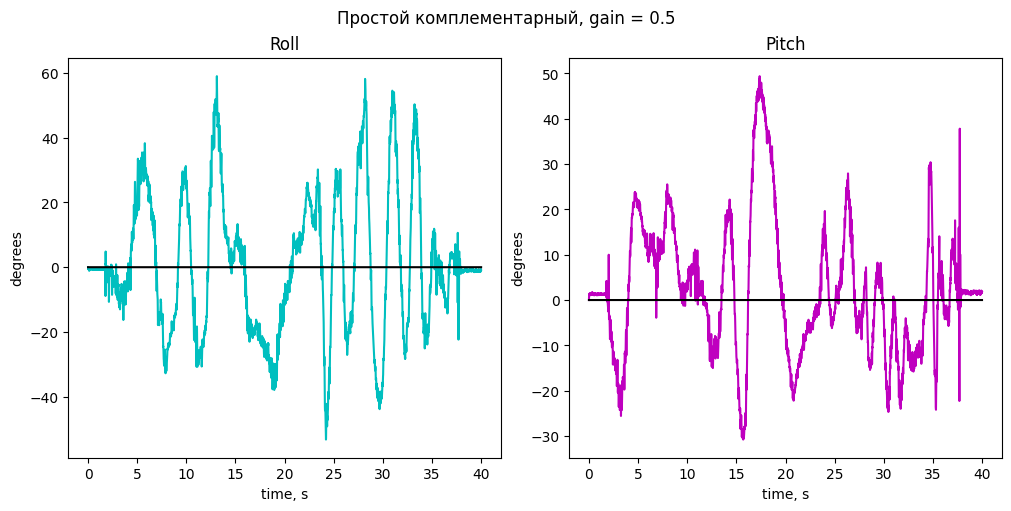

Avg roll:  1.00233
Std roll:  21.30076 

Avg pitch:  2.12593
Std pitch:  14.90751 



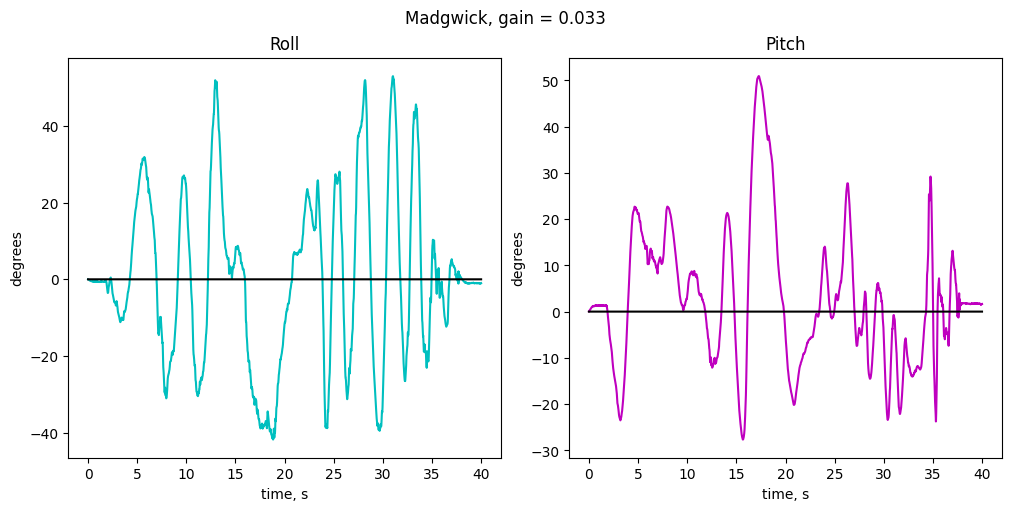

Avg roll:  0.28323
Std roll:  22.24740 

Avg pitch:  2.57487
Std pitch:  15.37763 



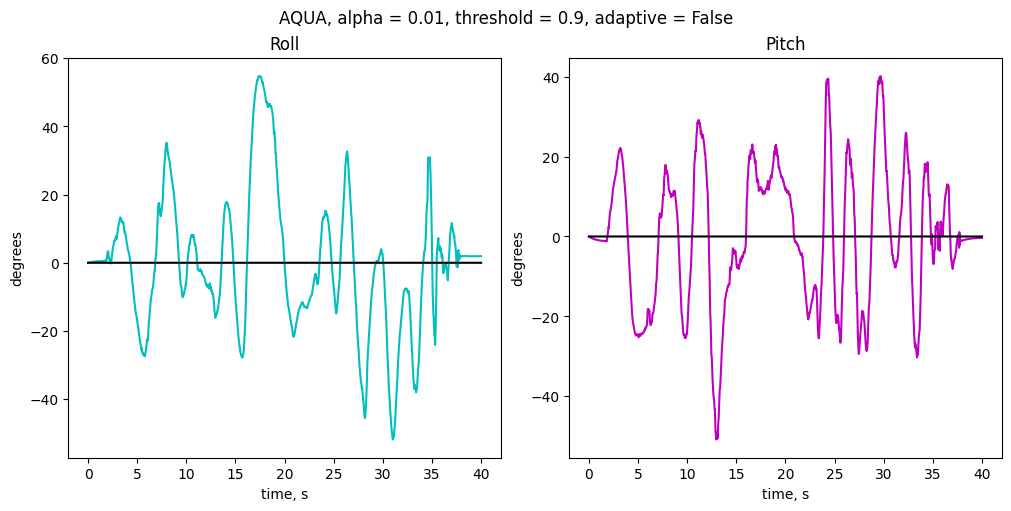

Avg roll:  -0.20836
Std roll:  20.17194 

Avg pitch:  0.11704
Std pitch:  17.27738 



In [19]:
process_data("data/40s_flightlike31.10.2023.18_28_51.json", "В движении, под разными углами", calib= {'a': {'x': -0.4446, 'y': -0.1665, 'z': 9.8 - 10.2432},
                                                                                                     'g': {'x': 4.9695, 'y': 2.4440, 'z': 2.1029}})